In [26]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from torchvision import datasets
from PIL import Image


In [27]:
class EuroSATDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # List all class directories, ignore .DS_Store files and directories
        self.classes = [class_name for class_name in os.listdir(root_dir) 
                        if os.path.isdir(os.path.join(root_dir, class_name)) and class_name != ".DS_Store"]
        
        self.image_paths = []
        self.labels = []
        
        # Collect all images and labels, ignoring .DS_Store files
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(".jpg") and img_name != ".DS_Store":  # Exclude .DS_Store
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")  # Ensure 3 channels (RGB)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


In [28]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to a fixed size (64x64)
    transforms.ToTensor(),        # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

In [29]:
root_dir = 'EuroSAT'  # Set the path to the EuroSAT dataset
dataset = EuroSATDataset(root_dir=root_dir, transform=transform)

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
CLASSES_DICT = dict(enumerate(dataset.classes))

In [30]:
class EuroSATModel(nn.Module):
    def __init__(self, num_classes=10):
        super(EuroSATModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Assuming input size is 64x64
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 8 * 8)  # Flatten the output
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [31]:
model = EuroSATModel(num_classes=10)  # EuroSAT has 10 classes

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [33]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/10], Loss: 0.8710
Epoch [2/10], Loss: 0.5182
Epoch [3/10], Loss: 0.3783
Epoch [4/10], Loss: 0.2721
Epoch [5/10], Loss: 0.2096
Epoch [6/10], Loss: 0.1453
Epoch [7/10], Loss: 0.1246
Epoch [8/10], Loss: 0.0915
Epoch [9/10], Loss: 0.0874
Epoch [10/10], Loss: 0.0667


In [34]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(all_labels, all_predictions))


Accuracy: 0.8981
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       644
           1       0.82      0.88      0.85       525
           2       0.86      0.83      0.85       489
           3       0.87      0.93      0.90       603
           4       0.93      0.98      0.95       578
           5       0.93      0.77      0.84       592
           6       0.94      0.96      0.95       460
           7       0.96      0.98      0.97       623
           8       0.81      0.82      0.81       496
           9       0.87      0.88      0.88       390

    accuracy                           0.90      5400
   macro avg       0.90      0.90      0.89      5400
weighted avg       0.90      0.90      0.90      5400



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


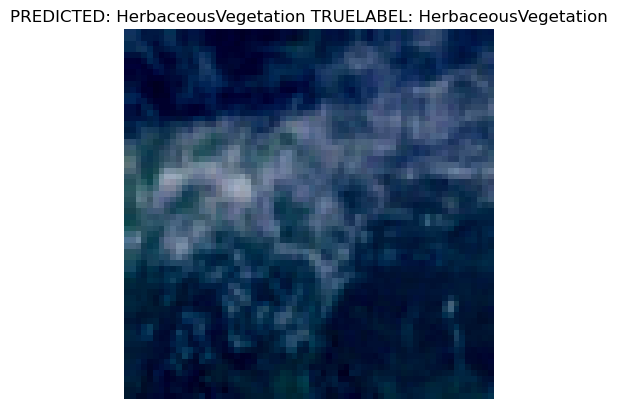

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


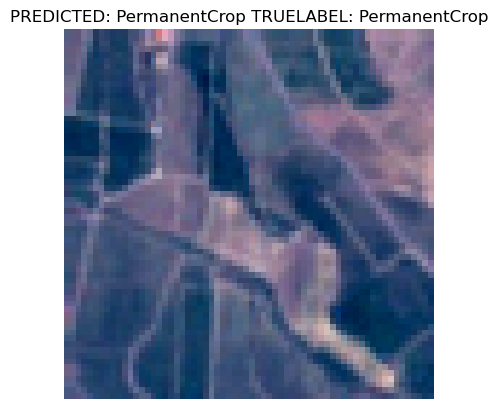

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


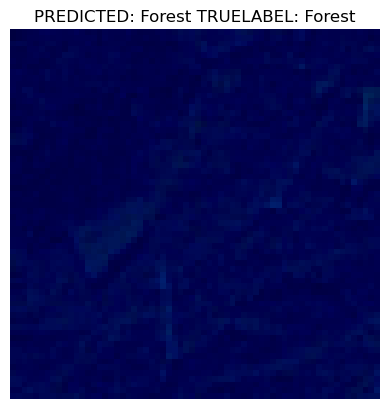

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


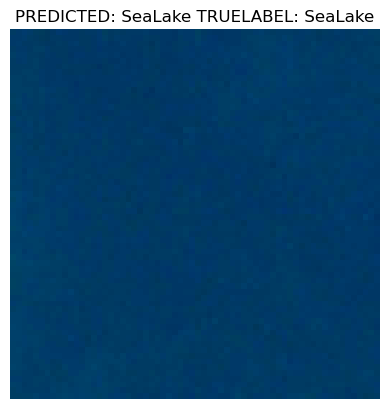

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


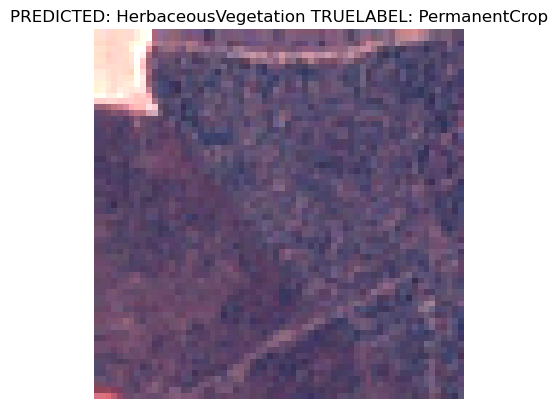

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


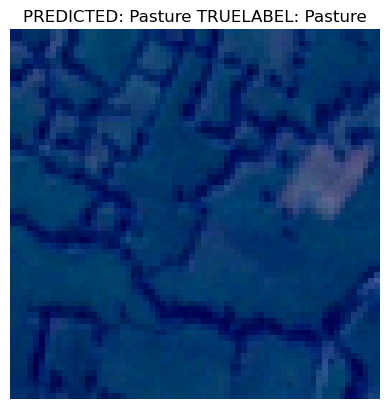

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


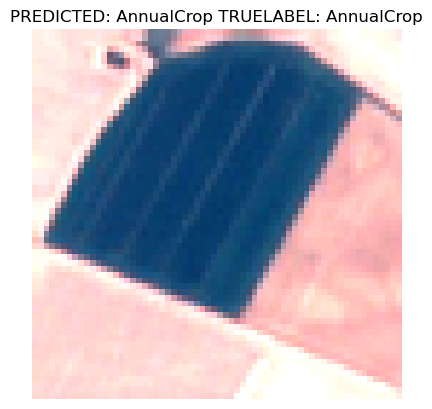

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


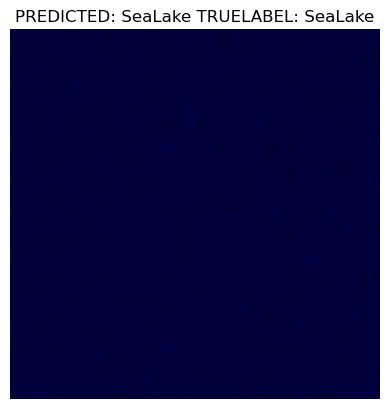

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


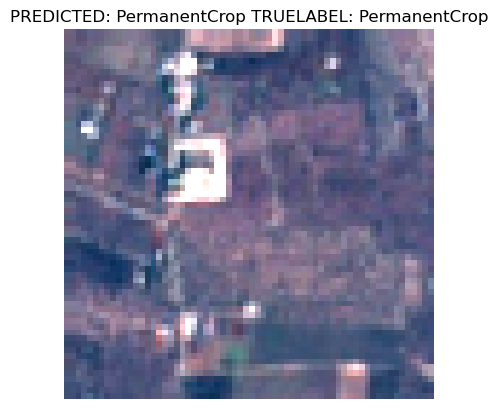

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


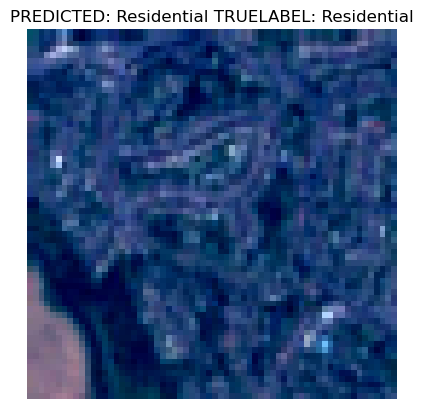

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


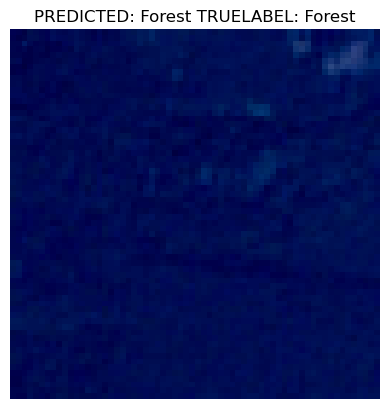

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


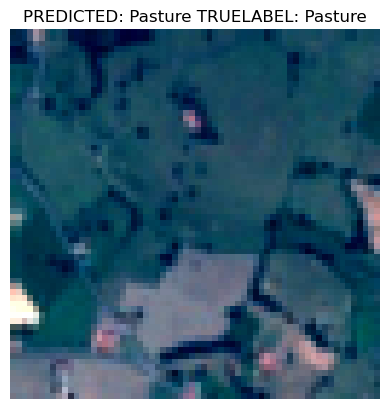

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


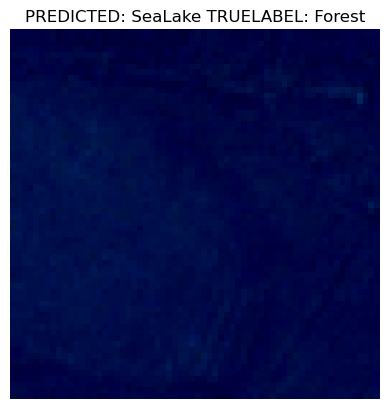

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


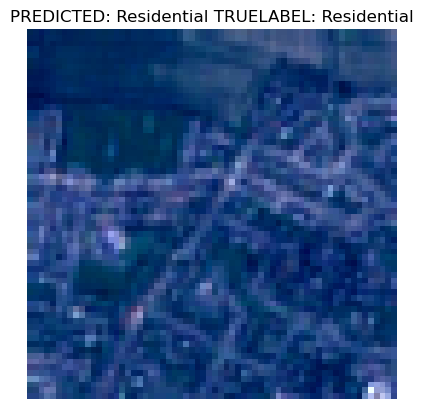

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


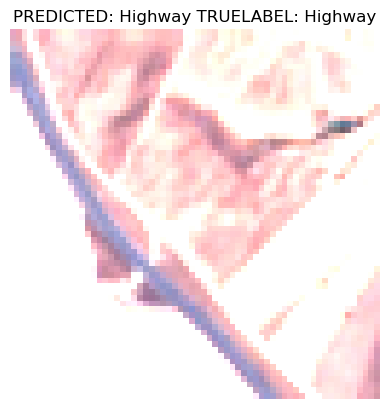

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


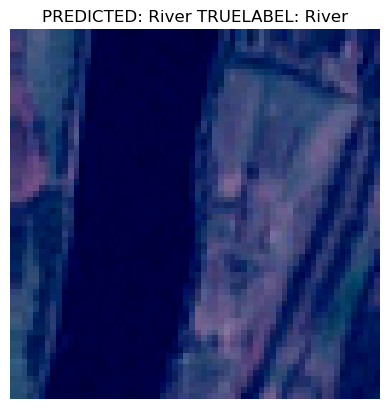

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


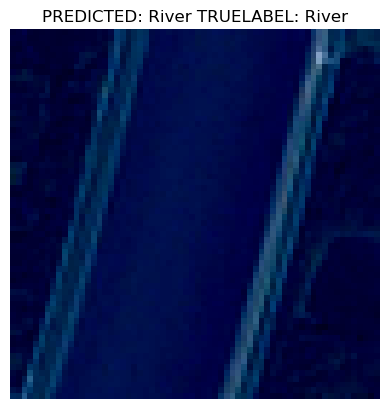

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


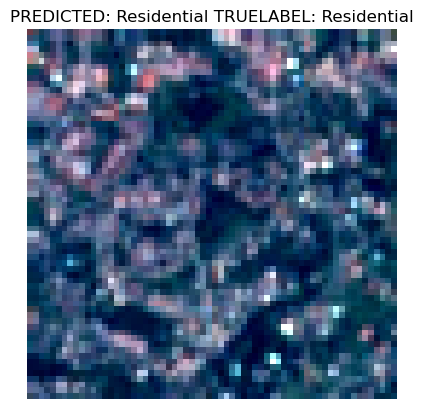

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


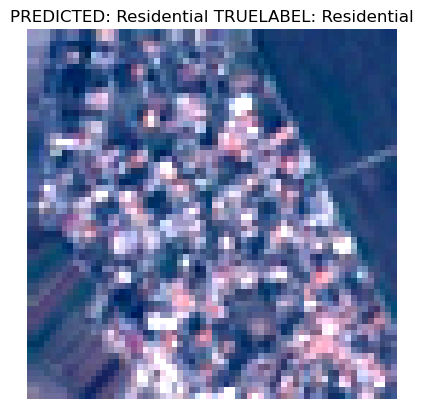

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


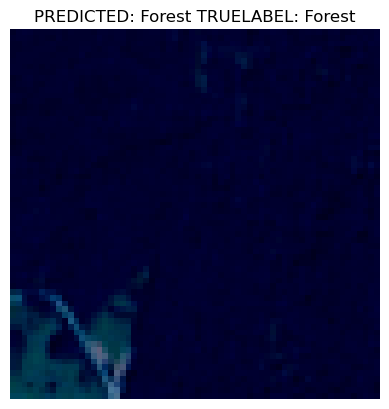

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


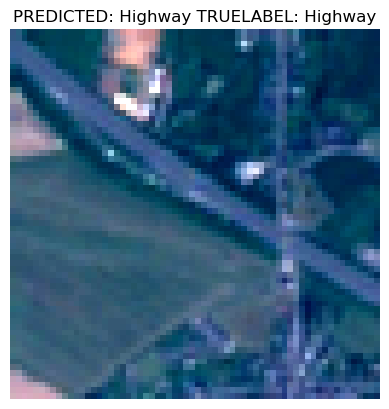

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


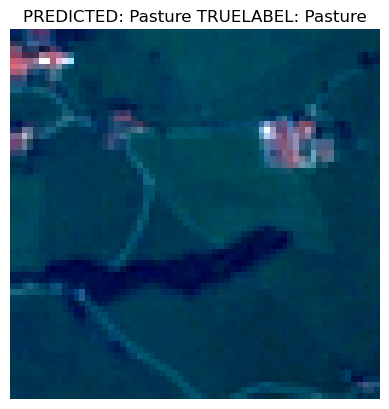

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


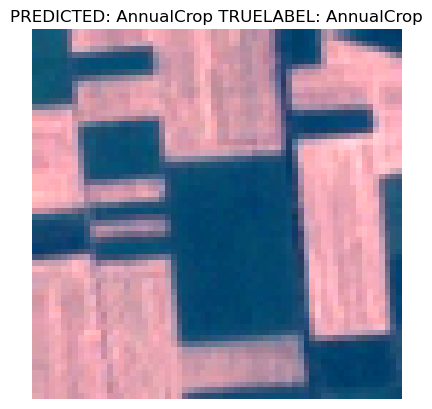

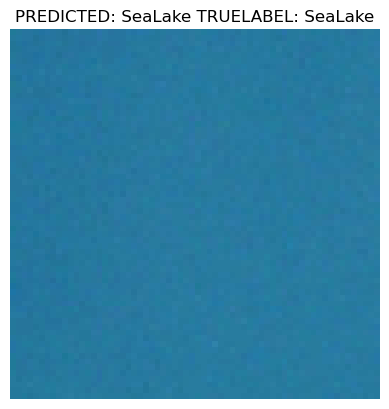

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


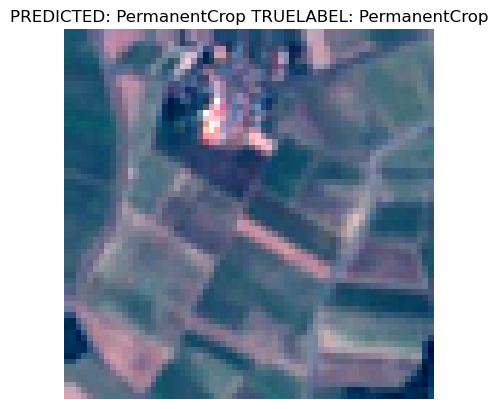

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


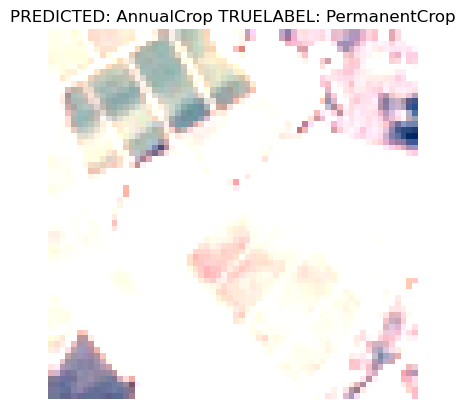

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


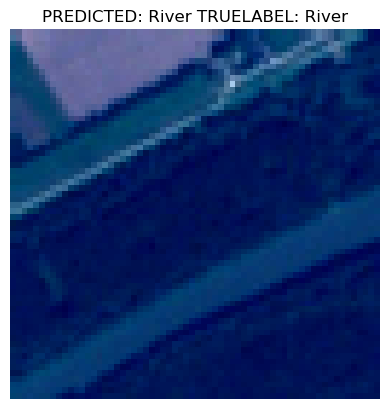

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


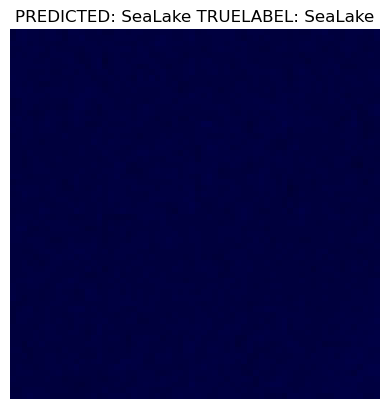

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


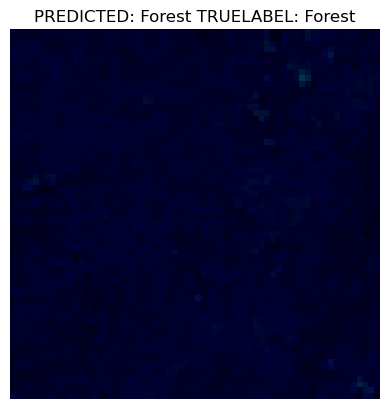

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


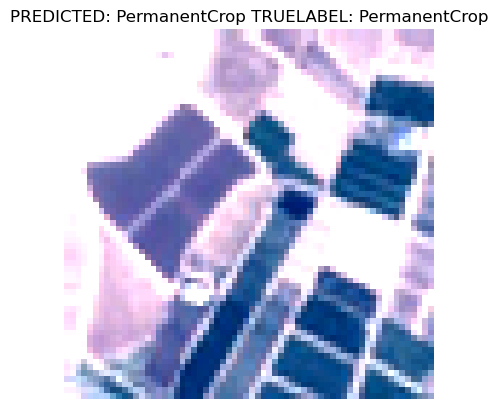

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


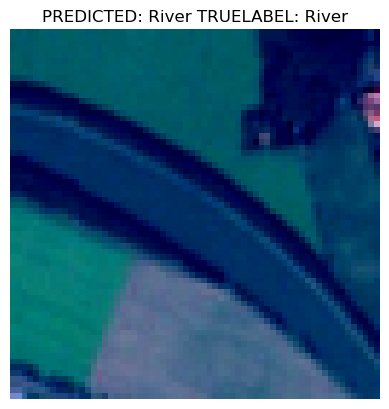

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


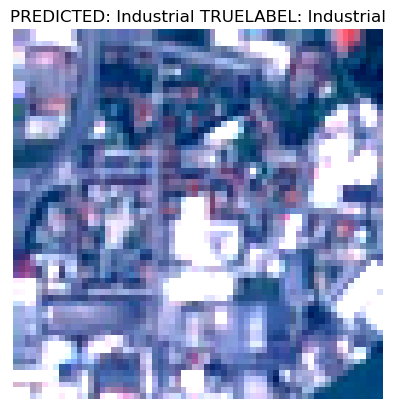

In [56]:

def imshow(img, true_label=None, pred_class=None):
    """Display a single image with its predicted class label."""
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

    plt.imshow(npimg)
    plt.axis('off')  # Hide axes

    # Display the predicted class if provided
    if pred_class is not None:
        plt.title(f'PREDICTED: {pred_class} TRUELABEL: {true_label}', fontsize=12, color='black')

    plt.show()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show each image with its prediction
for img, true_labels, pred in zip(images, labels, predicted):
    imshow(img, CLASSES_DICT[true_labels.item()], CLASSES_DICT[pred.item()])  # Convert tensor to label using dictionary
